In [1]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import cv2

%matplotlib inline

2025-05-22 23:03:12.312944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 23:03:12.722132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747954992.865733    2081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747954992.895468    2081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 23:03:13.166025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
images = []
target = []
img_size = 224
glaucoma_path = "./data/glaucoma/"
normal_path = "./data/normal/"

for file in os.listdir(glaucoma_path):
    image_path = glaucoma_path + file
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size,img_size))
    images.append(img)
    target.append(1)

for file in os.listdir(normal_path):
    image_path = normal_path + file
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size,img_size))
    images.append(img)
    target.append(0)

images = np.array(images).astype("float32")
images = images / 255.
target = np.array(target).astype("float32")

print(images.shape)
print(target.shape)

(1840, 224, 224, 3)
(1840,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.2, random_state=123, shuffle=True, stratify=target)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1472, 224, 224, 3)
(1472,)
(368, 224, 224, 3)
(368,)


In [11]:
# Baseline accuracy: predict most frequent class for every instance
print(np.unique(y_train, return_counts=True))
np.mean(y_train == 0)

(array([0., 1.], dtype=float32), array([883, 589]))


0.5998641304347826

### Pretrained VGG-16 Model

In [5]:
#pretrained vgg-16 model
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in vgg_model.layers:
    layer.trainable = False

from tensorflow.keras.models import Model

x = layers.Flatten()(vgg_model.output)
x = layers.Dense(4096, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs=vgg_model.input,outputs=output)
model.summary()

W0000 00:00:1747939471.770883    2180 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,969,089 (488.16 MB)

 Trainable params: 113,254,401 (432.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [7]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=25, callbacks=[early_stopping], validation_split=0.2, batch_size=128)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.5202 - loss: 7.6621 - val_accuracy: 0.6441 - val_loss: 0.9691
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.5726 - loss: 0.8722 - val_accuracy: 0.6441 - val_loss: 0.6439
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.6232 - loss: 0.6881 - val_accuracy: 0.3797 - val_loss: 0.7300
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.5862 - loss: 0.6408 - val_accuracy: 0.7220 - val_loss: 0.5695
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.7804 - loss: 0.5102 - val_accuracy: 0.4644 - val_loss: 1.0732
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.6511 - loss: 0.6759 - val_accuracy: 0.7051 - val_loss: 0.5559
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.8235 - loss: 0.4189 - val_accuracy: 0.7559 - val_loss: 0.5062
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - accuracy: 0.8532 - loss: 0.3454 - val_accuracy: 0.7763 - val_loss:

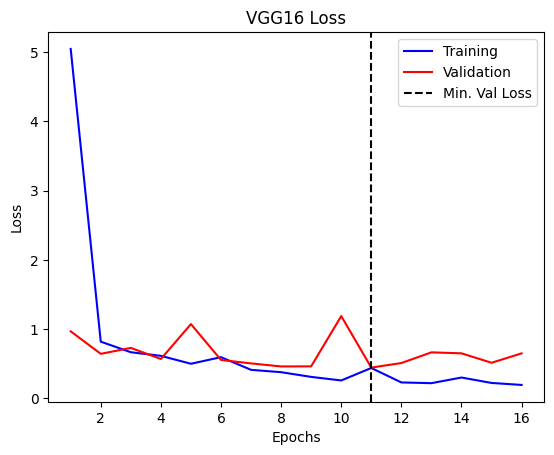

In [8]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
min_index = np.argmin(val_loss)

plt.plot(epochs,loss,'b',label="Training")
plt.plot(epochs,val_loss,'r',label="Validation")
plt.axvline(epochs[min_index],color="black",linestyle='--',label="Min. Val Loss")
plt.title("VGG16 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [9]:
model.save("./models/vgg16_model1.keras")

### Pretrained VGG-16 w/ ImageGen

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    #rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3)
train_generator = generator.flow(
    X_train,
    y_train,
    batch_size=128,
    seed=123,
    shuffle=True,
    subset="training")
validation_generator = generator.flow(
    X_train,
    y_train,
    batch_size=128,
    seed=123,
    shuffle=True,
    subset="validation"
)

In [29]:
x = layers.Flatten()(vgg_model.output)
x = layers.Dense(4096, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model2 = Model(inputs=vgg_model.input,outputs=output)
#model.summary()
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [30]:
history2 = model2.fit(train_generator, epochs=25, callbacks=[early_stopping], validation_data=validation_generator)

Epoch 1/25


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.5401 - loss: 8.6683 - val_accuracy: 0.6032 - val_loss: 0.9562
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.5062 - loss: 0.9232 - val_accuracy: 0.6032 - val_loss: 0.6900
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.6017 - loss: 0.6714 - val_accuracy: 0.6032 - val_loss: 0.6808
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.5978 - loss: 0.6729 - val_accuracy: 0.6054 - val_loss: 0.6972
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.5735 - loss: 0.6830 - val_accuracy: 0.6077 - val_loss: 0.6593
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.6364 - loss: 0.6279 - val_accuracy: 0.7279 - val_loss: 0.5619
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.7133 - loss: 0.5776 - val_accuracy: 0.6916 - val_loss: 0.5695
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - accuracy: 0.6903 - loss: 0.5697 - val_accuracy: 0.6644 - val_loss: 0.6041
Epoch 9/25
9/9 ━━━━

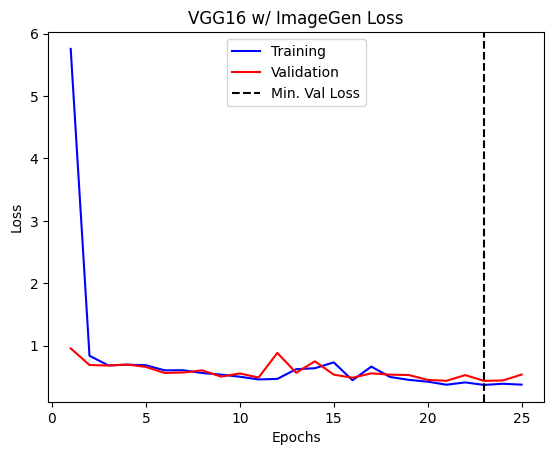

In [31]:
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1,len(loss)+1)
min_index = np.argmin(val_loss)

plt.plot(epochs,loss,'b',label="Training")
plt.plot(epochs,val_loss,'r',label="Validation")
plt.axvline(epochs[min_index],color="black",linestyle='--',label="Min. Val Loss")
plt.title("VGG16 w/ ImageGen Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [32]:
model2.save("./models/vgg16_imagegen_model.keras")

### VGG 16 as feature extractor for SVC

In [12]:
from tensorflow.keras.models import load_model

vgg16 = load_model("./models/vgg16_model1.keras")

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

feature_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.get_layer("dense_2").output)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step
11/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


In [14]:
vgg_svm_clf = SVC(kernel="linear")
n_splits = 5
cv_splits = KFold(n_splits)

scores = cross_val_score(vgg_svm_clf, train_features, y_train, cv=cv_splits, scoring="accuracy")

print(f"Accuracy: {100*scores}")
print(f"Mean Accuracy: {100*np.mean(scores):.2f}")

Accuracy: [92.20338983 91.52542373 91.49659864 90.13605442 79.59183673]
Mean Accuracy: 88.99


In [17]:
vgg_ig_svm_clf = SVC(kernel="linear")

vgg16_ig = load_model("./models/vgg16_imagegen_model.keras")
vgg16_ig.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,477,893 (1.32 GB)

 Trainable params: 113,254,401 (432.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 226,508,804 (864.06 MB)

In [18]:
feature_extractor_ig = keras.Model(inputs=vgg16_ig.inputs, outputs=vgg16_ig.get_layer("dense_10").output)
train_features_ig = feature_extractor_ig.predict(X_train)
test_features_ig = feature_extractor_ig.predict(X_test)

scores = cross_val_score(vgg_ig_svm_clf, train_features_ig, y_train, cv=cv_splits, scoring="accuracy")
print(f"Accuracy: {100*scores}")
print(f"Mean Accuracy: {100*np.mean(scores):.2f}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
11/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Accuracy: [77.96610169 85.76271186 85.71428571 85.37414966 81.97278912]
Mean Accuracy: 83.36


In [19]:
vgg_svm_clf.fit(train_features, y_train)
vgg_ig_svm_clf.fit(train_features_ig, y_train)

SVC(kernel='linear')

In [20]:
from sklearn.metrics import accuracy_score, f1_score

In [21]:
def evaluate_accuracy(model,input,y_true):
    y_pred = model.predict(input)
    return 100 * accuracy_score(y_pred,y_true)

def evaluate_f1_score(model,input,y_true):
    y_pred = model.predict(input)
    return f1_score(y_true, y_pred, average="weighted")

In [22]:
print("--- Training Accuracy ---")
print(f"VGG-16: {vgg16.evaluate(X_train,y_train)}")
print(f"VGG-16 ImageGen: {vgg16_ig.evaluate(X_train,y_train)}")

print("--- Testing Accuracy ---")
print(f"VGG-16: {vgg16.evaluate(X_test,y_test)}")
print(f"VGG-16 ImageGen: {vgg16_ig.evaluate(X_test,y_test)}")

--- Training Accuracy ---
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9174 - loss: 0.2481
VGG-16: [0.29040318727493286, 0.889266312122345]
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8104 - loss: 0.4255
VGG-16 ImageGen: [0.39305752515792847, 0.82472825050354]
--- Testing Accuracy ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8086 - loss: 0.4591
VGG-16: [0.47842469811439514, 0.79347825050354]
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7791 - loss: 0.4817
VGG-16 ImageGen: [0.533586323261261, 0.7527173757553101]


In [23]:
print("Training Accuracy")
print(f"VGG16 + SVM: {evaluate_accuracy(vgg_svm_clf,train_features,y_train):.2f}")
print(f"VGG16 + IG + SVM: {evaluate_accuracy(vgg_ig_svm_clf,train_features_ig,y_train):.2f}")

print("Testing Accuracy")
print(f"VGG16 + SVM: {evaluate_accuracy(vgg_svm_clf,test_features,y_test):.2f}")
print(f"VGG16 + IG + SVM: {evaluate_accuracy(vgg_ig_svm_clf,test_features_ig,y_test):.2f}")

Training Accuracy


VGG16 + SVM: 89.47
VGG16 + IG + SVM: 83.70
Testing Accuracy
VGG16 + SVM: 78.80
VGG16 + IG + SVM: 77.99


In [24]:
print("F1-Score - Training")
print(f"VGG16 + SVM: {evaluate_f1_score(vgg_svm_clf,train_features,y_train):.2f}")
print(f"VGG16 + IG + SVM: {evaluate_f1_score(vgg_ig_svm_clf,train_features_ig,y_train):.2f}")

print("F1-Score - Testing")
print(f"VGG16 + SVM: {evaluate_f1_score(vgg_svm_clf,test_features,y_test):.2f}")
print(f"VGG16 + IG + SVM: {evaluate_f1_score(vgg_ig_svm_clf,test_features_ig,y_test):.2f}")

F1-Score - Training
VGG16 + SVM: 0.89
VGG16 + IG + SVM: 0.83
F1-Score - Testing
VGG16 + SVM: 0.79
VGG16 + IG + SVM: 0.77
